In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 도입

#### 병원 개/폐업 분류 예측 경진대회

#### 2020.12.15  
 
1. baseline code.  
2. 변수 탐색 x -> 결측값만.  
3. ~~~시간 변수 처리 수치화 어떻게 모델에 잘 녹일지. (일단 year,month,day 빼기)~~
4. ~~평균,중앙값 중 어떤걸 대체. (일단 평균)  ~~
5. 모델 선택. (scikit-learn cheet sheet)     
    5-1. LinearSVC 는 안먹힌다. convergen?   
    5-2. SVC 실행 시 [Libsvm] 계속 먹통. -> kernel='linear' 로 해결. 
        5-2-1. kernel : 방법?
    
#### 2020.12.16

~~1. 모델 설명하는 shap로 하고 변수들의 중요도 파악 후 데이터 분석    
    1-1. 위가 맞는지 분석을 하고 모델에 넣고 중요도를 파악하는게 맞는지.  
    1-2. shap 로 했지만, 교차검증으로 한 모델들은 클래스를 한개밖에 못읽는다. 그렇게 된거? ~~
    
~~2. shap로 나온 특성들을 우선 분석.~~

#### 2020.12.18

1. 코드 공유를 봤는데 간단한 전처리만 했다.
2. 의사 결정 트리가 생각보다 쎈거같다.
3. 각각의 모델마다 다른 결과값들이 나온다. 그래서 합해야 하는것 같다. 다음엔 randomforest로 하기.

#### 2020.12.21

1. 모델   
    1-1. 의사결정트리    
    1-2. naive bayes    
    1-3. support vector machine.  
    1-4. logistic regression.  
    1-5. decision tree.
        * 문제점 : 왜인지 같은 점수가 나온다. ~~비슷해서?~~ 데이터셋 수가 적어서.
2. 스케일
    2-1. ~~minmax 사용. -> 레이블값도 0,1 로 다같이 스케일을 통일.~~
        * scale 을 사용하는 이유 : 모델에도 계수가 있다고 한다. 특성마다 가질 수 있는 값의 스케일이 크게 차이가 나면 문제가 생기기도 한다. 정형화(regulation)는 과학습(overfitting)이 발생하는 것을 방지하기 위한 장치다. 과학습이 발생하면 특정 입력값에 대한 머신러닝 모델의 계수가 커진다. 하지만 입력값의 열마다 가질 수 있는 값의 범위에 크게 차이가 생기면 과학습의 발생 여부와 상관없이 각 입력값에 모델 계수 스케일도 크게 차이가 생겨서 정형화가 정상적으로 작동하지 않는다.
     
#### ~~2020.12.22~~ 2020.12.23(수정)

1. hold out - 전체를 train 과 test 로 나눠서 훈련. 여기서 발전이 k-fold 
2. one-hot encoding vs label encoding  -> 웬만하면 label encoding 과 frequency encoding
    * label 인코딩은 rank 를 생각하고 한게 아닌데도 숫자개념때문에 순서가 생긴다. 
        * 순서가 있을때 하면 좋다. 
        * 내용이 많이 있을때 하면 좋다. 
    * one hot 인코딩은 더미 트랩을 일으켜 다중공선성(독립 특성간 종속성)이 발생한다.
        * 순서가 없을때 
        * 내용이 많이 없을때 하면 좋다.
3. smote 
    * 오버샘플링,언더샘플링 기법. 
    * lightgbm 실험가치 있다.

4. 다중대입법.

#### 2020.12.23(수정)

1. xgboost의 장점
    - ~~결측값 자동처리 - 나머지 모델들도 가능한지?~~ 아직 실험중 1.13.0 버전
    - ~~xgboost random_state 가 따로없다. colsample_bytree 와 sumsample 로 해결.~~ seed 가있었다.

#### 2020.12.24

1. 우승자코드 분석.
    1-1. 1등 
        train,test 특히 범주형 column의 level 맞춰주기 -> train,test 환경이 비슷해야한다. 같이 인코딩하기
        R은 factor형도 xgboost에 가능한거 같다. -> 범주형 변수 처리 고민.
        여기는 데이터가 적은데 깊이 10에 num_boost_round 2000으로 땡겼다. -> 물어보기.
        regression 사용.
        파생변수 -> 2016년과 2017년 차이.

### 2020.12.28 

1. 보팅,배깅,부스팅 차이   
    1-1. 보팅 : 소프트 ( 확률 평균 ) ,하드 ( 최빈값 )  
    1-2. 배깅 : 여러개로 나눠서 학습한것을 다수결로  
    1-3. 부스팅 : 여러개의 분류기의 가중 학습을 거쳐 결정된다.      
    이 모든 것을 아우르는 앙상블.



In [8]:

# 필요한 라이브러리

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# 데이터 불러오기 

train=pd.read_csv('/content/drive/MyDrive/colab전용/data02/train.csv')
test=pd.read_csv('/content/drive/MyDrive/colab전용/data02/test.csv')
submission=pd.read_csv('/content/drive/MyDrive/colab전용/data02/submission_sample.csv')

In [10]:
# 합치기

n=train.shape[0]
data=pd.concat([train,test],axis=0).reset_index(drop=True)

In [11]:
def datainfo(df):
    return pd.DataFrame([(col,df[col].nunique(),df[col].isna().sum(),df[col].dtype,df[col].unique()[:5]) 
                        for col in df.columns],columns=['name','nunique','missing','dtype','value :5'])

In [12]:
# datainfo(data)

In [13]:
data['employee1']=data['employee1'].astype('str').str.replace(',','').astype('float')
data['employee2']=data['employee2'].astype('str').str.replace(',','').astype('float')

train.csv - 의료기관이 폐업했는지 여부를 포함하여 최근 2개년의 재무정보와 병원 기본정보 

test.csv - 폐업 여부를 제외하고 train.csv와 동일 

sample_submission.csv - inst_id와 open과 close를 예측하는 OC 두개의 열로 구성. OC의 값은 open 예측일 경우 1, close 예측일 경우 0.



inst_id - 각 파일에서의 병원 고유 번호

OC – 영업/폐업 분류, 2018년 폐업은 2017년 폐업으로 간주함

sido – 병원의 광역 지역 정보

sgg – 병원의 시군구 자료

openDate – 병원 설립일

bedCount - 병원이 갖추고 있는 병상의 수

instkind – 병원, 의원, 요양병원, 한의원, 종합병원 등 병원의 종류

·        종합병원 : 입원환자 100명 이상 수용 가능

·        병원 : 입원 환자 30명 이상 100명 미만 수용 가능

·        의원 : 입원 환자 30명 이하 수용 가능

·        한방 병원(한의원) : 침술과 한약으로 치료하는 의료 기관.  

 

revenue1 – 매출액, 2017(회계년도)년 데이터를 의미함

salescost1 – 매출원가, 2017(회계년도)년 데이터를 의미함

sga1 - 판매비와 관리비, 2017(회계년도)년 데이터를 의미함

salary1 – 급여, 2017(회계년도)년 데이터를 의미함

noi1 – 영업외수익, 2017(회계년도)년 데이터를 의미함

noe1 – 영업외비용, 2017(회계년도)년 데이터를 의미함

Interest1 – 이자비용, 2017(회계년도)년 데이터를 의미함

ctax1 – 법인세비용, 2017(회계년도)년 데이터를 의미함

Profit1 – 당기순이익, 2017(회계년도)년 데이터를 의미함

liquidAsset1 – 유동자산, 2017(회계년도)년 데이터를 의미함

quickAsset1 – 당좌자산, 2017(회계년도)년 데이터를 의미함

receivableS1 - 미수금(단기), 2017(회계년도)년 데이터를 의미함

inventoryAsset1 – 재고자산, 2017(회계년도)년 데이터를 의미함

nonCAsset1 – 비유동자산, 2017(회계년도)년 데이터를 의미함

tanAsset1 – 유형자산, 2017(회계년도)년 데이터를 의미함

OnonCAsset1 - 기타 비유동자산, 2017(회계년도)년 데이터를 의미함

receivableL1 – 장기미수금, 2017(회계년도)년 데이터를 의미함

debt1 – 부채총계, 2017(회계년도)년 데이터를 의미함

liquidLiabilities1 – 유동부채, 2017(회계년도)년 데이터를 의미함

shortLoan1 – 단기차입금, 2017(회계년도)년 데이터를 의미함

NCLiabilities1 – 비유동부채, 2017(회계년도)년 데이터를 의미함

longLoan1 – 장기차입금, 2017(회계년도)년 데이터를 의미함

netAsset1 – 순자산총계, 2017(회계년도)년 데이터를 의미함

surplus1 – 이익잉여금, 2017(회계년도)년 데이터를 의미함

 

revenue2 – 매출액, 2016(회계년도)년 데이터를 의미함

salescost2 – 매출원가, 2016(회계년도)년 데이터를 의미함

sga2 - 판매비와 관리비, 2016(회계년도)년 데이터를 의미함

salary2 – 급여, 2016(회계년도)년 데이터를 의미함

noi2 – 영업외수익, 2016(회계년도)년 데이터를 의미함

noe2 – 영업외비용, 2016(회계년도)년 데이터를 의미함

interest2 – 이자비용, 2016(회계년도)년 데이터를 의미함

ctax2 – 법인세비용, 2016(회계년도)년 데이터를 의미함

profit2 – 당기순이익, 2016(회계년도)년 데이터를 의미함

liquidAsset2 – 유동자산, 2016(회계년도)년 데이터를 의미함

quickAsset2 – 당좌자산, 2016(회계년도)년 데이터를 의미함

receivableS2 - 미수금(단기), 2016(회계년도)년 데이터를 의미함

inventoryAsset2 – 재고자산, 2016(회계년도)년 데이터를 의미함

nonCAsset2 – 비유동자산, 2016(회계년도)년 데이터를 의미함

tanAsset2 – 유형자산, 2016(회계년도)년 데이터를 의미함

OnonCAsset2 - 기타 비유동자산, 2016(회계년도)년 데이터를 의미함

receivableL2 – 장기미수금, 2016(회계년도)년 데이터를 의미함

Debt2 – 부채총계, 2016(회계년도)년 데이터를 의미함

liquidLiabilities2 – 유동부채, 2016(회계년도)년 데이터를 의미함

shortLoan2 – 단기차입금, 2016(회계년도)년 데이터를 의미함

NCLiabilities2 – 비유동부채, 2016(회계년도)년 데이터를 의미함

longLoan2 – 장기차입금, 2016(회계년도)년 데이터를 의미함

netAsset2 – 순자산총계, 2016(회계년도)년 데이터를 의미함

surplus2 – 이익잉여금, 2016(회계년도)년 데이터를 의미함

employee1 – 고용한 총 직원의 수, 2017(회계년도)년 데이터를 의미함

employee2 – 고용한 총 직원의 수, 2016(회계년도)년 데이터를 의미함

ownerChange – 대표자의 변동 

### 재무 도메인 지식

<h4>용어정리</h4>

매출액 (=영업수익) : 쉽게 말해 수입 +  
매출원가  : 매출액을 올리는데 들어가는 비용 -  
매출총이익 : 매출액 - 매출원가   
판매비와 관리비 (=판관비) : 유지비용 -   
영업이익 : 매출총이익 - 판관비  
세전이익 : 영업이익 + 영업외수익 - 영업외비용  
영업외손익: 영업 외적으로 생긴 손익 (매출액 대비 영업외손익 수준 파악)  
법인세 : 기업에 부과하는 세   
당기순이익 : 기업의 최종수익 -> 세전이익 - 법인세    
매출액순이익율 : 당기순이익/매출액  
유동자산 : 1년내에 현금화 가능한 자산 (=당좌좌산 + 재고자산)  
당좌자산 : 바로 현금화 가능한 자산 (미수금 등 포함)  
비유동자산 : 현금화에 1년이상 걸리는 자산   
유형자산 : 토지, 건물, 기계장치 같은.   
무형자산 : 특허 등.  
단기차입급 : 1년이내에 갚아야할 자산    
비유동부채 : 만기가 1년이상 이후에 도래하는것. (장기차입급)   
유동성장기부채  
채권발행(사채)    
장기차입급 : 차입급 지급기한이 1년을 초과하는것. 장기적으로 약속할때 쓰임.  
이익잉여금 : 법정자본액을 초과한 금액. 
이자보상배율 : 한해수입 중 이자가 얼마인지 파악하는 지표. (=영업이익/이자비용)  
유동비율 : 1년내에 현금으로 바꿀수있는 자산이 1년내에 갚아야할 부채보다 많은 정도.  

In [14]:
# train['OC'].value_counts()

In [15]:
factor_columns=data.select_dtypes(include=['object']).columns
numeric_columns=data.columns.difference(factor_columns)

data[factor_columns]=data[factor_columns].fillna('notsure')
data[numeric_columns]=data[numeric_columns].fillna(-999)

In [16]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()

for col in ['sido','instkind','ownerChange']:
    data[col]=encoder.fit_transform(data[col])

In [17]:
data

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,2,73,20071228.0,175.0,5,4.217530e+09,0.000000e+00,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,31641798.0,2.251697e+08,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,0.0,6.828260e+08,2.013237e+08,0.000000e+00,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,0.000000e+00,4.057422e+09,2.063787e+09,16194675.0,2.998335e+07,1.568305e+07,18808074.0,2.078297e+08,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,2
1,3,open,9,32,19970401.0,410.0,2,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-999.0,-9.990000e+02,-9.990000e+02,-999.0,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-999.0,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-999.0,-9.990000e+02,-9.990000e+02,-999.0,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-999.0,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,801.0,813.0,2
2,4,open,8,89,20161228.0,468.0,5,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,0.0,4.186475e+07,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,0.000000e+00,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,2
3,7,open,10,141,20000814.0,353.0,2,7.250734e+10,0.000000e+00,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,173769780.0,9.028303e+08,1.304154e+10,1.153475e+10,0.000000e+00,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,0.0,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,0.000000e+00,6.492419e+10,2.971135e+10,476807804.0,1.353672e+09,1.277422e+09,218891720.0,8.383875e+08,1.112572e+10,9.890540e+09,0.000000e+00,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,2
4,9,open,9,32,20050901.0,196.0,2,4.904354e+10,0.000000e+00,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,0.0,8.074970e+07,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,0.0,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,0.000000e+00,4.712580e+10,2.346004e+10,597748128.0,1.522108e+09,1.349851e+09,0.0,3.264258e+07,4.906776e+09,4.464017e+09,3.365227e+09,4.427591e+08,4.653138e+10,4.562945e+10,7.893407e+08,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [18]:
# bedCount,opendate,ownerChange,noe,interest,profit,employee,newasset,revenue 가 중요해보인다.

In [19]:
# 각종 지표

import warnings
warnings.filterwarnings("ignore")

# 유동자산/단기차입금  : 1년이내에 갚을돈이 많은지 정도.
data['rateofliquid1']=data['liquidAsset1']/data['shortLoan1']
data.loc[data['rateofliquid1']==np.inf,'rateofliquid1']=0
data.loc[data['rateofliquid1'].isna(),'rateofliquid1']=-999

# 총자산증가율
# data1['rateofasset']=data1['netAsset1']/data1['netAsset2']-1
# data1.loc[data1['rateofasset']==-1,'rateofasset']=-999

# 총매출증가율
# data1['rateofrevenue']=data1['revenue1']/data1['revenue2']-1
# data1.loc[data1['rateofrevenue']==-1,'rateofrevenue']=-999

# 자산/부채+자산 비율
data['rateofownasset1']=1/(1+(data['debt1']/data['netAsset1']))
data.loc[data['rateofownasset1'].isna(),'rateofownasset1']=-999

# 이익 %
data['rateofprofit1']=data['profit1']/(data['revenue1']+1)

# 정리
data=data.drop(['liquidAsset2','revenue2','profit2','shortLoan2','surplus2',
            'quickAsset2','debt2','netAsset2'],axis=1)

In [20]:
new_train=data.iloc[:n,:]
new_test=data.iloc[n:,:]

X_train=new_train.drop('OC',axis=1)
y_train=np.where(new_train['OC']=='open',1,0)
X_test=new_test.drop('OC',axis=1)

In [21]:
# gradient boosting.

import xgboost as xgb

dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test)

params={
    'objective':'binary:logistic',
    'seed':71
}
bst=xgb.train(params,dtrain)
pred_xgb=bst.predict(dtest)


In [22]:
# ensemble 

from sklearn.ensemble import RandomForestClassifier

params={
    'random_state':71
}

model=RandomForestClassifier(**params)

model.fit(X_train,y_train)
pred_rf=model.predict_proba(X_test)

pred_rf=pred_rf[:,1]

In [23]:
# !pip install catboost

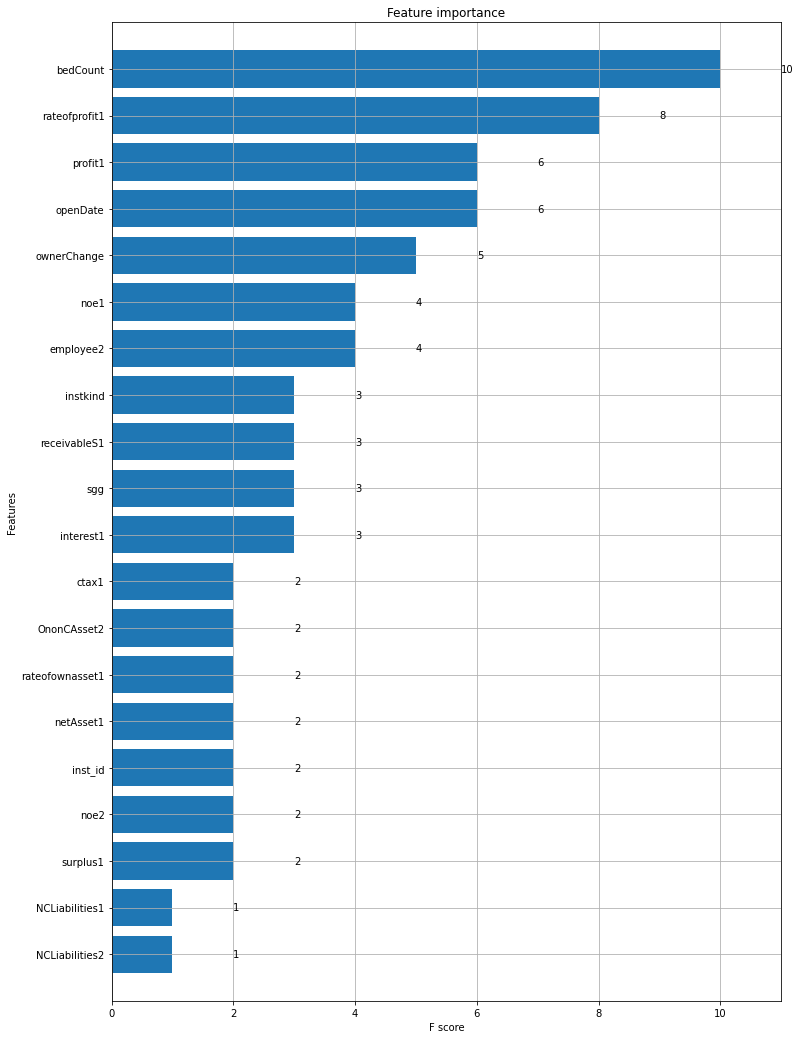

In [24]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [25]:
from catboost import CatBoostClassifier

params={
    'random_seed':71,
    'num_boost_round':10
}

model=CatBoostClassifier(**params)

model.fit(X_train,y_train)

pred_cat=model.predict_proba(X_test)

pred_cat=pred_cat[:,1]

Learning rate set to 0.421
0:	learn: 0.3231057	total: 64.5ms	remaining: 580ms
1:	learn: 0.1831020	total: 77.8ms	remaining: 311ms
2:	learn: 0.1393509	total: 91.4ms	remaining: 213ms
3:	learn: 0.1074914	total: 105ms	remaining: 157ms
4:	learn: 0.0844430	total: 118ms	remaining: 118ms
5:	learn: 0.0638235	total: 132ms	remaining: 87.9ms
6:	learn: 0.0497449	total: 145ms	remaining: 62.1ms
7:	learn: 0.0445554	total: 158ms	remaining: 39.5ms
8:	learn: 0.0404674	total: 171ms	remaining: 19ms
9:	learn: 0.0357419	total: 185ms	remaining: 0us


In [26]:
pred=pred_xgb*0.4+pred_rf*0.3+pred_cat*0.3

In [27]:
pred=[1 if x>0.7 else 0 for x in pred]
submission['OC']=pred

In [28]:
# submission.to_csv('/content/drive/MyDrive/kagglestudy/data02/xgb4_rf3_cat3_2020.12.28.csv',index=False)